The code examples build a working, executable prototype: an app to classify phone SMS messages in English (well, the "SMS kind" of English...) as either "spam" or "ham" (=not spam).

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import _pickle as cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier 

In [83]:
# https://archive.ics.uci.edu/ml/machine-learning-databases/00228/
messages = [line.rstrip() for line in open('./SMSSpamCollection',  encoding="utf8")]

In [84]:
print(len(messages))

5574


In [85]:
print(messages[:1])

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...']


In [86]:
for message_nr, message in enumerate(messages[:10]):
    print(message_nr, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

In [87]:
messages = pandas.read_csv('./SMSSpamCollection', sep='\t' , quoting=csv.QUOTE_NONE,
                           names=["label", "message"])

In [88]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [89]:
messages.describe()

,label,message
count,5574,5574
unique,2,5171
top,ham,"Sorry, I'll call later"
freq,4827,30


In [90]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4827   4518                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [91]:
messages['length'] = messages['message'].map(lambda text: len(text))
messages.head(15).sort_values(by='length', ascending=False)

,label,message,length
13,ham,I've been searching for the right words to tha...,196
7,ham,As per your request 'Melle Melle (Oru Minnamin...,160
8,spam,WINNER!! As a valued network customer you have...,157
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
12,spam,URGENT! You have won a 1 week FREE membership ...,155
9,spam,Had your mobile 11 months or more? U R entitle...,154
5,spam,FreeMsg Hey there darling it's been 3 week's n...,147
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",136
0,ham,"Go until jurong point, crazy.. Available only ...",111
10,ham,I'm gonna be home soon and i don't want to tal...,109


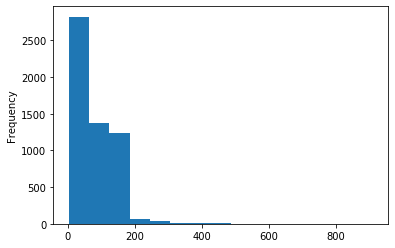

In [92]:
messages['length'].plot(bins=15 , kind='hist');

In [93]:
messages['length'].describe()

count    5574.000000
mean       80.478292
std        59.848302
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [94]:
#Review the longest sms
print(list(messages.message[messages.length >900]))

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


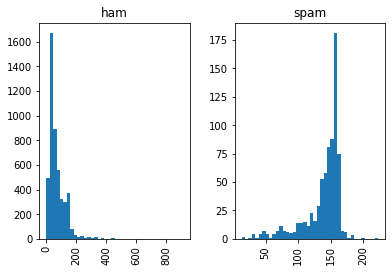

In [95]:
messages.hist(column = 'length', by='label', bins=40);

Data preprocessing

#Splitting the data into separated words
def split_into_words(message):
    message = unicode(message, 'utf8')
    return TextBlob(message).words

In [96]:
def split_into_words(message):
    return message.split()

In [97]:
messages.message.head()

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
Name: message, dtype: object

In [98]:
messages.message.head().apply(split_into_words)

0    [Go, until, jurong, point,, crazy.., Available...
1                 [Ok, lar..., Joking, wif, u, oni...]
2    [Free, entry, in, 2, a, wkly, comp, to, win, F...
3    [U, dun, say, so, early, hor..., U, c, already...
4    [Nah, I, don't, think, he, goes, to, usf,, he,...
Name: message, dtype: object

In [99]:
from textblob import TextBlob

In [100]:
TextBlob("Hello world, how is it going?").tags

[('Hello', 'NNP'),
 ('world', 'NN'),
 ('how', 'WRB'),
 ('is', 'VBZ'),
 ('it', 'PRP'),
 ('going', 'VBG')]

In [101]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [102]:
messages.message.head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object


Step 3: Data to vectors
Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

Doing that requires essentially three steps, in the bag-of-words model:

1. Counting how many times does a word occur in each message (term frequency)
2. Weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

Let's take one text message and get its bag-of-words counts as a vector, putting to use our new bow_transformer:

In [103]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))

8857


In [104]:
message4 = messages['message'][3]
print(message4)

U dun say so early hor... U c already then say...


In [105]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 1156)	1
  (0, 1895)	1
  (0, 2891)	1
  (0, 2921)	1
  (0, 4015)	1
  (0, 6724)	2
  (0, 7099)	1
  (0, 7685)	1
  (0, 8000)	2
(1, 8857)


So, nine unique words in message nr. 4, two of them appear twice, the rest only once. Sanity check: what are these words the appear twice?

In [106]:
print(bow_transformer.get_feature_names()[6736])
print(bow_transformer.get_feature_names()[8013])

scenario
ugo


The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:

In [107]:
messages_bow = bow_transformer.transform(messages['message'])
print ('sparse matrix shape:', messages_bow.shape)
print ('number of non-zeros:', messages_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5574, 8857)
number of non-zeros: 80340
sparsity: 0.16%


And finally, after the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer:

In [108]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print (tfidf4)

  (0, 8000)	0.30500390244920195
  (0, 7685)	0.22530830435091123
  (0, 7099)	0.19139747787841085
  (0, 6724)	0.5233907074133691
  (0, 4015)	0.4563719925781256
  (0, 2921)	0.329688073969027
  (0, 2891)	0.30370462627268274
  (0, 1895)	0.24665241656533501
  (0, 1156)	0.27494440163841516


What is the IDF (inverse document frequency) of the word "u"? Of word "university"?

In [109]:
print (tfidf_transformer.idf_[bow_transformer.vocabulary_['u']])
print (tfidf_transformer.idf_[bow_transformer.vocabulary_['university']])

2.8495406039561364
8.239753235208429


To transform the entire bag-of-words corpus into TF-IDF corpus at once:

In [110]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print (messages_tfidf.shape)

(5574, 8857)


Step 4: Training a model, detecting spam

With messages represented as vectors, we can finally train our spam/ham classifier. This part is pretty straightforward, and there are many libraries that realize the training algorithms.

We'll be using scikit-learn here, choosing the Naive Bayes classifier to start with:

In [111]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

Wall time: 22 ms


Let's try classifying our single random message:

In [112]:
print ('predicted:', spam_detector.predict(tfidf4)[0])
print ('expected:', messages.label[3])

predicted: ham
expected: ham


A natural question is to ask, how many messages do we classify correctly overall?

In [113]:
all_predictions = spam_detector.predict(messages_tfidf)
print (all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [114]:
print ('accuracy', accuracy_score(messages['label'], all_predictions))
print ('confusion matrix\n', confusion_matrix(messages['label'], all_predictions))
print ('(row=expected, col=predicted)')

accuracy 0.9695012558306423
confusion matrix
 [[4827    0]
 [ 170  577]]
(row=expected, col=predicted)


<Figure size 1080x360 with 0 Axes>

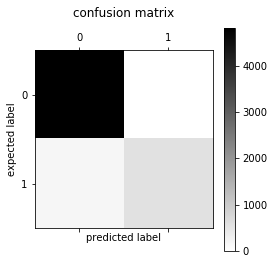

In [115]:
plt.figure(figsize=(15,5));
plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest');
figure_title = 'confusion matrix'
plt.title(figure_title, y=1.15);
plt.colorbar();
plt.ylabel('expected label');
plt.xlabel('predicted label');

In [116]:
print (classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98      4827
        spam       1.00      0.77      0.87       747

    accuracy                           0.97      5574
   macro avg       0.98      0.89      0.93      5574
weighted avg       0.97      0.97      0.97      5574



In [117]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print (len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4459 1115 5574


In [118]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [119]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print (scores)

[0.94854586 0.94843049 0.95515695 0.96188341 0.95515695 0.94170404
 0.96412556 0.95067265 0.96629213 0.93483146]


In [120]:
print (scores.mean(), scores.std())

0.9526799501646206 0.009441850380025778


In [121]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Wall time: 0 ns


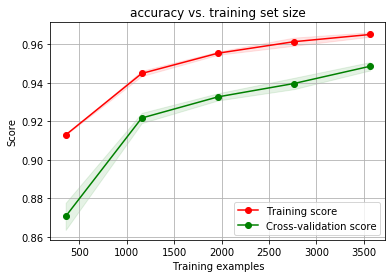

In [122]:
%time 
plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5);

We can ask: What is the effect of IDF weighting on accuracy? Does the extra processing cost of lemmatization (vs. just plain words) really help?

Let's find out:

In [123]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_words),
}
skf=StratifiedKFold(n_splits=5)

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=skf  # what type of cross validation to use
)

In [124]:
%time nb_detector = grid.fit(msg_train, label_train)
print (nb_detector.cv_results_)

Wall time: 16.4 s
{'mean_fit_time': array([3.99870253, 3.67748642, 0.17090154, 0.16530523]), 'std_fit_time': array([0.07792025, 0.54141624, 0.00303246, 0.00257531]), 'mean_score_time': array([1.02780743, 0.87869396, 0.02758226, 0.02818213]), 'std_score_time': array([0.01008621, 0.19172676, 0.00080042, 0.00278408]), 'param_bow__analyzer': masked_array(data=[<function split_into_lemmas at 0x0000029C2EC2A6A8>,
                   <function split_into_lemmas at 0x0000029C2EC2A6A8>,
                   <function split_into_words at 0x0000029C2EBFE0D0>,
                   <function split_into_words at 0x0000029C2EBFE0D0>],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_tfidf__use_idf': masked_array(data=[True, False, True, False],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'bow__analyzer': <function split_into_lemmas at 0x0000029C2EC2A6A8>, 'tfidf__use_idf': True}, {'bow

In [125]:
print (nb_detector.predict_proba(["Hi mom, how are you?"])[0])
print (nb_detector.predict_proba(["WINNER! Credit for free!"])[0])

[0.99390914 0.00609086]
[0.30959845 0.69040155]


In [126]:
print (nb_detector.predict(["Hi mom, how are you?"])[0])
print (nb_detector.predict(["WINNER! Credit for free!"])[0])

ham
spam


In [127]:
predictions = nb_detector.predict(msg_test)
print (confusion_matrix(label_test, predictions))
print (classification_report(label_test, predictions))

[[969   0]
 [ 55  91]]
              precision    recall  f1-score   support

         ham       0.95      1.00      0.97       969
        spam       1.00      0.62      0.77       146

    accuracy                           0.95      1115
   macro avg       0.97      0.81      0.87      1115
weighted avg       0.95      0.95      0.95      1115




Let's try with another classifier: Support Vector Machines (SVM). SVMs are a great starting point when classifying text data, getting state of the art results very quickly and with pleasantly little tuning (although a bit more than Naive Bayes):

In [128]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

skf = StratifiedKFold(n_splits=5)

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=skf,  # what type of cross validation to use
)

In [129]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm
print (svm_detector.cv_results_)

Wall time: 1min 48s
{'mean_fit_time': array([5.13964591, 5.99395461, 5.84963703, 5.34913015, 5.43807397,
       5.35454068, 5.74011865, 5.66634302, 6.40851693, 5.93039117,
       5.44247088, 5.31054769]), 'std_fit_time': array([0.21065558, 0.49787407, 0.57582326, 0.01541048, 0.03805957,
       0.03642385, 0.13066149, 0.05176384, 0.32926452, 0.07539246,
       0.19679022, 0.05717786]), 'mean_score_time': array([1.33922963, 1.42617984, 1.239888  , 1.33043447, 1.25427818,
       1.29545503, 1.35402141, 1.31444421, 1.40099387, 1.49374151,
       1.27326808, 1.22409635]), 'std_score_time': array([0.09982875, 0.16327289, 0.02110275, 0.0391605 , 0.01924605,
       0.01306808, 0.05753581, 0.01436387, 0.03594215, 0.12196426,
       0.0422556 , 0.04529184]), 'param_classifier__C': masked_array(data=[1, 10, 100, 1000, 1, 1, 10, 10, 100, 100, 1000, 1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?'

In [130]:
print (svm_detector.predict(["Hi mom, how are you?"])[0])
print (svm_detector.predict(["WINNER! Credit for free!"])[0])

ham
spam


In [131]:
print (confusion_matrix(label_test, svm_detector.predict(msg_test)))
print (classification_report(label_test, svm_detector.predict(msg_test)))

[[965   4]
 [ 19 127]]
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       969
        spam       0.97      0.87      0.92       146

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



This is then the realistic predictive performance we can expect from our spam detection pipeline, when using SVMs.

In [166]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(TfidfTransformer(), RandomForestClassifier())
sorted(pipeline.get_params().keys())

['memory',
 'randomforestclassifier',
 'randomforestclassifier__bootstrap',
 'randomforestclassifier__class_weight',
 'randomforestclassifier__criterion',
 'randomforestclassifier__max_depth',
 'randomforestclassifier__max_features',
 'randomforestclassifier__max_leaf_nodes',
 'randomforestclassifier__min_impurity_decrease',
 'randomforestclassifier__min_impurity_split',
 'randomforestclassifier__min_samples_leaf',
 'randomforestclassifier__min_samples_split',
 'randomforestclassifier__min_weight_fraction_leaf',
 'randomforestclassifier__n_estimators',
 'randomforestclassifier__n_jobs',
 'randomforestclassifier__oob_score',
 'randomforestclassifier__random_state',
 'randomforestclassifier__verbose',
 'randomforestclassifier__warm_start',
 'steps',
 'tfidftransformer',
 'tfidftransformer__norm',
 'tfidftransformer__smooth_idf',
 'tfidftransformer__sublinear_tf',
 'tfidftransformer__use_idf',
 'verbose']

In [187]:
pipeline_rfc = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])

params = {"classifier__max_depth": [4,5,6,7,8],
              "classifier__max_features": ['auto', 'sqrt', 'log2'],
              "classifier__n_estimators" : [200,500],
              #"classifier__min_samples_split": [1, 3, 10],
              #"classifier__min_samples_leaf": [1, 3, 10],
              # "bootstrap": [True, False],
              "classifier__criterion": ["gini", "entropy"]}

skf=StratifiedKFold(n_splits=5)

grid_rfc = GridSearchCV(
    pipeline_rfc,# pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=skf  # what type of cross validation to use
)

In [188]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=42)

In [189]:
label_train.head()

1968     ham
4283     ham
2932     ham
4169    spam
3530    spam
Name: label, dtype: object

In [190]:
%time rfc_detector = grid_rfc.fit(msg_train, label_train) # find the best combination from param_svm


Wall time: 9min 16s


CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)

CV_rfc.fit(msg_train, label_train)

In [191]:
print (rfc_detector.cv_results_)

{'mean_fit_time': array([7.32939563, 5.34555392, 4.72908216, 5.52042704, 4.6265398 ,
       5.29235792, 4.73128014, 5.57139726, 4.71329083, 5.58019176,
       4.63793416, 5.3069488 , 4.78065143, 5.73872008, 4.80723648,
       5.64975247, 4.63553514, 5.81965413, 5.56561413, 7.54346356,
       6.90024753, 8.20053596, 6.39105949, 7.56405268, 6.11868315,
       6.72013721, 5.54121585, 6.77890377, 5.85283589, 5.72970567,
       5.03830318, 5.79586782, 5.4104897 , 7.50028915, 5.36451645,
       7.61942043, 6.15526195, 6.75751543, 6.11908283, 8.11953273,
       6.09209843, 5.82565184, 5.10266619, 6.58001685, 5.47825065,
       6.60320415, 5.04030232, 6.09929366, 5.55680556, 6.5798295 ,
       5.61477189, 6.33615756, 5.28476286, 6.73912535, 5.23259182,
       6.20075579, 5.62916427, 7.43624272, 5.63895874, 6.06851168]), 'std_fit_time': array([1.44230315, 0.09895976, 0.0688264 , 0.04161555, 0.02701269,
       0.03015933, 0.01337875, 0.00972232, 0.02063721, 0.03529273,
       0.02211062, 0.03173

In [192]:
grid_rfc.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 500}

In [195]:
print (confusion_matrix(label_test, rfc_detector.predict(msg_test)))
print (classification_report(label_test, rfc_detector.predict(msg_test)))

[[969   0]
 [131  15]]
              precision    recall  f1-score   support

         ham       0.88      1.00      0.94       969
        spam       1.00      0.10      0.19       146

    accuracy                           0.88      1115
   macro avg       0.94      0.55      0.56      1115
weighted avg       0.90      0.88      0.84      1115



In [196]:
print (rfc_detector.predict(["Hi mom, how are you?"])[0])
print (rfc_detector.predict(["WINNER! Credit for free!"])[0])

ham
ham
